In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries
import torch
import torch.nn as nn
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython import display
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
display.set_matplotlib_formats('svg')

In [ ]:
new_data = pd.read_csv("PATH/ml_sample4.csv")
# new_data=pd.concat([data[data["class"]==1],data[data["class"]==0].sample(12840)]);
# new_data = new_data.sample(frac=1).reset_index(drop=True)
new_data.head

<bound method NDFrame.head of        location  description  url  ...  profile_banner_url  entities.url.urls  class
0             1           32    0  ...                   0                  0      0
1             1          146    0  ...                   0                  0      1
2             0           49    0  ...                   1                  0      1
3             1            0    0  ...                   0                  0      0
4             1           45    0  ...                   0                  0      1
...         ...          ...  ...  ...                 ...                ...    ...
13267         0           28    1  ...                   0                  1      1
13268         0          146    0  ...                   0                  0      1
13269         0            0    0  ...                   0                  0      0
13270         1          158    1  ...                   0                  1      0
13271         0            0    0  

# Import and process the data

In [ ]:
labels = torch.tensor( new_data['class'] ).long()
new_data=new_data.drop(['class'],axis=1) 

# data.loc[:, data.columns != 'class'].apply(stats.zscore)
new_data=new_data.apply(stats.zscore);
sample = torch.tensor(new_data.values).float()


In [ ]:
new_data.head()

,location,description,url,followers_count,friends_count,listed_count,favourites_count,geo_enabled,verified,statuses_count,profile_background_image_url_https,profile_background_tile,profile_image_url,profile_use_background_image,has_extended_profile,default_profile,default_profile_image,profile_banner_url,entities.url.urls
0,0.910553,-0.221512,-0.49854,-0.019630,-0.136554,-0.050326,-0.195904,-0.695629,-0.076888,-0.156151,0.485190,-0.484241,0.122431,0.320742,-0.585123,0.865226,-0.122431,-1.102920,-0.49854
1,0.910553,2.070779,-0.49854,-0.007354,0.708574,-0.047225,0.575777,-0.695629,-0.076888,-0.045990,0.485190,-0.484241,0.122431,0.320742,-0.585123,0.865226,-0.122431,-1.102920,-0.49854
2,-1.098234,0.120321,-0.49854,-0.005243,0.094875,-0.013107,0.210128,1.437548,-0.076888,1.192807,0.485190,-0.484241,0.122431,0.320742,1.709043,-1.155767,-0.122431,0.906684,-0.49854
3,0.910553,-0.864962,-0.49854,-0.018094,-0.140687,-0.048776,-0.181673,1.437548,-0.076888,-0.135196,0.485190,2.065085,0.122431,0.320742,-0.585123,-1.155767,-0.122431,-1.102920,-0.49854
4,0.910553,0.039890,-0.49854,-0.016773,-0.032893,-0.008454,1.355336,1.437548,-0.076888,0.323493,-2.061049,-0.484241,0.122431,0.320742,1.709043,0.865226,-0.122431,-1.102920,-0.49854


In [ ]:
sample

tensor([[ 0.9106, -0.2215, -0.4985,  ..., -0.1224, -1.1029, -0.4985],
        [ 0.9106,  2.0708, -0.4985,  ..., -0.1224, -1.1029, -0.4985],
        [-1.0982,  0.1203, -0.4985,  ..., -0.1224,  0.9067, -0.4985],
        ...,
        [-1.0982, -0.8650, -0.4985,  ..., -0.1224, -1.1029, -0.4985],
        [ 0.9106,  2.3121,  2.0059,  ..., -0.1224, -1.1029,  2.0059],
        [-1.0982, -0.8650, -0.4985,  ..., -0.1224,  0.9067, -0.4985]])

In [ ]:
train_data,test_data, train_labels,test_labels = train_test_split(sample, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)


# train and test dataloaders
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset,batch_size=64, shuffle=True, drop_last=True)

# Create the ANN model

In [ ]:
# create a class for the model

class ANN_CLASS_MODEL(nn.Module):
  def __init__(self,nUnits,nLayers):
    super().__init__()

    # create dictionary to store the layers
    self.layers = nn.ModuleDict()
    self.nLayers = nLayers

    ### input layer
    self.layers['input'] = nn.Linear(19,nUnits)
    
    ### hidden layers
    for i in range(nLayers):
      self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)
      self.layers[f'batch{i}'] = nn.BatchNorm1d(nUnits)


    ### output layer
    self.layers['output'] = nn.Linear(nUnits,2)
  

  # forward pass
  def forward(self,x,useBatchLayer=True):
    # input layer
    x = F.relu(self.layers['input'](x))

    # hidden layers
    for i in range(self.nLayers):
      if useBatchLayer:
        x = F.relu(self.layers[f'batch{i}'](self.layers[f'hidden{i}'](x)))
      else:
        x = F.relu(self.layers[f'hidden{i}'](x))

    return self.layers['output'](x)

In [ ]:
ml_model = ANN_CLASS_MODEL(64,1)
ml_model

ANN_CLASS_MODEL(
  (layers): ModuleDict(
    (input): Linear(in_features=19, out_features=64, bias=True)
    (hidden0): Linear(in_features=64, out_features=64, bias=True)
    (batch0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (output): Linear(in_features=64, out_features=2, bias=True)
  )
)

# Train the model

In [ ]:
def lost_function():
  return nn.BCEWithLogitsLoss()

In [ ]:
def model_optimizer(model,lr):
    return torch.optim.SGD(model.parameters(),lr=lr);

In [ ]:
def executing_model(model,num_epochs,lr):
  optimizer_instance=model_optimizer(model,lr);
  lost_function_instance=lost_function();

  losses_per_epoch = torch.zeros(num_epochs)


  for epochi in range(num_epochs):

    # forward pass
    model_prediction = model(train_data)
    loss = lost_function_instance(model_prediction,train_labels)
    losses_per_epoch[epochi] = loss


    # backprop
    optimizer_instance.zero_grad()
    loss.backward()
    optimizer_instance.step()

  predictions = model(train_data)
  pred_labels = torch.argmax(predictions,axis=1)
  totalacc = 100*torch.mean((pred_labels == train_labels).float())


  return losses_per_epoch,predictions,totalacc            

In [ ]:
learning_rates = np.linspace(.001,1,100)

# initialize
accByLR = []
all_losses = np.zeros((len(learning_rates),100))


# the loop
for i,lr in enumerate(learning_rates):
  
  
  losses,predictions,totalacc = executing_model(ml_model,100,0.2)

  # store the results
  accByLR.append(totalacc)
  all_losses[i,:] = losses.detach()

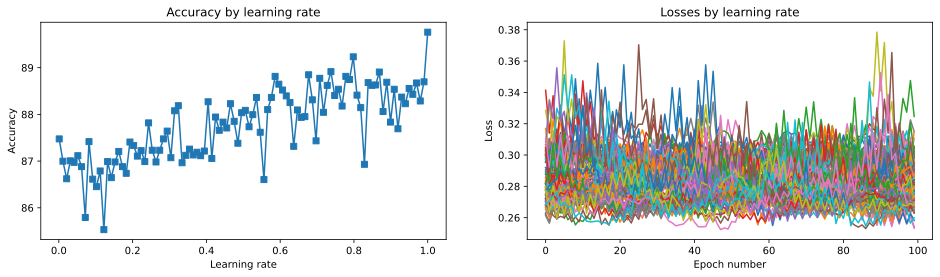

In [ ]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(16,4))

ax[0].plot(learning_rates,accByLR,'s-')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by learning rate')

ax[1].plot(all_losses.T)
ax[1].set_title('Losses by learning rate')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
plt.show()